# 1. Preparation

The ease of access to numerous sources of news on the internet also makes the problem of individuals been exposed to fake-news and perhaps believing them. We need to detect and flag such news on the internet. With the current rate of news generated on social media, it is difficult to distinguish between genuine news and fabrications without identifying the source of the story. This project tries to detect fake news using only the text without using any other related data.  

This prediction helps us to recognize between the fake news and true news. We have 55,000. We can say approximately half of it is fake news. In this project by using two different recurrent neural networks, we try to predict the accuracy of news by using two main features including the category of news and the article. So, this binary classification is many to one sequence classification.

## 1.1. Define and prepare your class variables

In [60]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
#from wordcloud import WordCloud,STOPWORDS
#from nltk.stem import WordNetLemmatizer
#from nltk.tokenize import word_tokenize,sent_tokenize
#from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
import tensorflow as tf


In [2]:
true = pd.read_csv("True.csv")
false = pd.read_csv("Fake.csv")
true['category'] = 0
false['category'] = 1
df = pd.concat([true,false]) #Merging the 2 datasets

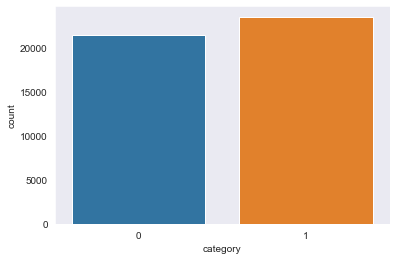

In [3]:
sns.set_style("dark")
sns.countplot(df.category)

In [4]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

## 1.2. Choose and explain evaluation metric

As accuracy is primarily affected by a large number of True Negatives, which in our project we do not focus on much, it cannot be a good choice for model evaluation. In contrast, false negative and false positives usually associated with costs; therefore, F1 Score might be a better measure to use, since we also can provide a balance between precision and recall, and also there is an uneven class distribution.

In [5]:
# define f1 score to use in Keras
import keras.backend as K

# https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## 1.3. Divide your data

In [6]:
x_train,x_test,y_train,y_test = train_test_split(df.text,df.category,random_state = 0)

In [7]:
max_features = 10000
maxlen = 300

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [8]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

# 2. Modeling

## 2.1. Investigate two different recurrent network architectures (LSTM and Simple RNN)

In [9]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers.embeddings import Embedding

NUM_CLASSES=1
EMBED_SIZE = 50

input_holder = Input(shape=(x_train.shape[1], ))
input_embed = Embedding(max_features, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=maxlen)(input_holder) # number of words in each sequence


x = SimpleRNN(25,dropout=0.2, recurrent_dropout=0.2)(input_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
rnn=Model(inputs=input_holder,outputs=x)
rnn.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=[f1])


In [43]:
print(rnn.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 50)           500000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 25)                1900      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 501,926
Trainable params: 501,926
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers.embeddings import Embedding

shared_embed = Embedding(max_features, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=maxlen)(input_holder) 


x = LSTM(50, dropout=0.2, recurrent_dropout=0.2)(shared_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
lstm=Model(inputs=input_holder,outputs=x)
lstm.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=[f1])
print(lstm.summary())


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 300, 50)           500000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 520,251
Trainable params: 520,251
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

lstm_history=lstm.fit(x_train, y_train,validation_data=(X_test, y_test),
                                        epochs=50, batch_size=64,
                                        callbacks=[EarlyStopping(monitor='val_loss', patience=5),
                                                   ModelCheckpoint(filepath='lstm_best.hdf5', monitor='val_loss',
                                                                   save_best_only=True),
                                                   ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)])
   

C:\Users\Hedieh\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Hedieh\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33673 samples, validate on 11225 samples
Epoch 1/50
33673/33673 [==============================] - 136s 4ms/step - loss: 0.1264 - f1: 0.9591 - val_loss: 0.0330 - val_f1: 0.9903
Epoch 2/50
33673/33673 [==============================] - 139s 4ms/step - loss: 0.0278 - f1: 0.9913 - val_loss: 0.0263 - val_f1: 0.9915
Epoch 3/50
33673/33673 [==============================] - 134s 4ms/step - loss: 0.0206 - f1: 0.9934 - val_loss: 0.0257 - val_f1: 0.9912
Epoch 4/50
33673/33673 [==============================] - 146s 4ms/step - loss: 0.0170 - f1: 0.9946 - val_loss: 0.0240 - val_f1: 0.9920
Epoch 5/50
33673/33673 [==============================] - 133s 4ms/step - loss: 0.0137 - f1: 0.9957 - val_loss: 0.0290 - val_f1: 0.9917
Epoch 6/50
33673/33673 [==============================] - 135s 4ms/step - loss: 0.0130 - f1: 0.9961 - val_loss: 0.0277 - val_f1: 0.9929
Epoch 7/50
33673/33673 [==============================] - 131s 4ms/step - loss: 0.0104 - f1: 0.9972 - val_loss: 0.0222 - val_f1: 0.993

In [ ]:
yhat_lstm = lstm.predict(X_test)

In [41]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

rnn_history=rnn.fit(x_train, y_train,validation_data=(X_test, y_test), epochs=50, batch_size=64,
                                        callbacks=[EarlyStopping(monitor='val_loss', patience=5),
                                                   ModelCheckpoint(filepath='gru_best.hdf5', monitor='val_loss',
                                                                   save_best_only=True),
                                                   ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)])
    

C:\Users\Hedieh\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Hedieh\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 33673 samples, validate on 11225 samples
Epoch 1/50
33673/33673 [==============================] - 66s 2ms/step - loss: 0.5747 - f1: 0.6819 - val_loss: 0.3448 - val_f1: 0.9138
Epoch 2/50
33673/33673 [==============================] - 69s 2ms/step - loss: 0.2343 - f1: 0.9119 - val_loss: 0.0679 - val_f1: 0.9787
Epoch 3/50
33673/33673 [==============================] - 69s 2ms/step - loss: 0.0914 - f1: 0.9721 - val_loss: 0.0571 - val_f1: 0.9814
Epoch 4/50
33673/33673 [==============================] - 65s 2ms/step - loss: 0.0636 - f1: 0.9801 - val_loss: 0.0444 - val_f1: 0.9869
Epoch 5/50
33673/33673 [==============================] - 65s 2ms/step - loss: 0.0514 - f1: 0.9853 - val_loss: 0.0630 - val_f1: 0.9797
Epoch 6/50
33673/33673 [==============================] - 60s 2ms/step - loss: 0.0422 - f1: 0.9880 - val_loss: 0.0483 - val_f1: 0.9841
Epoch 7/50
33673/33673 [==============================] - 60s 2ms/step - loss: 0.0369 - f1: 0.9895 - val_loss: 0.0471 - val_f1: 0.9860
Epoch

In [50]:
yhat_rnn = rnn.predict(X_test)

## 2.2.  Visualize the results of all the RNNs you trained.

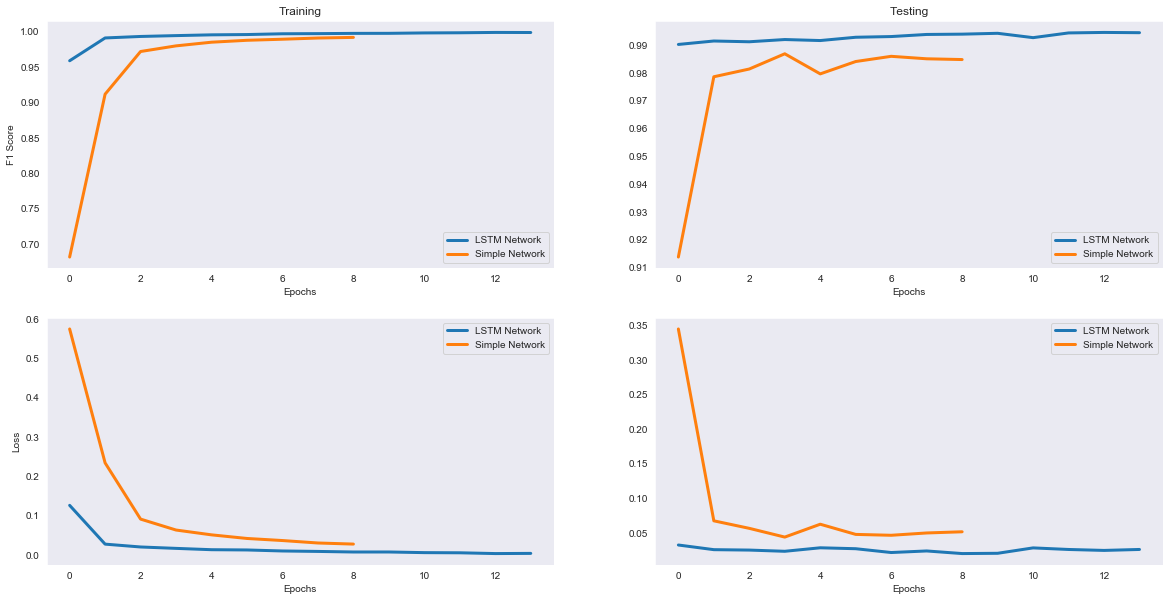

In [45]:
# plot the performance over the epochs
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.plot(lstm_history.history['f1'], lw=3.0)
plt.plot(rnn_history.history['f1'], lw=3.0)
plt.ylabel('F1 Score')
plt.xlabel('Epochs')
plt.title('Training')
plt.legend(['LSTM Network', 'Simple Network'])

plt.subplot(2,2,2)
plt.plot(lstm_history.history['val_f1'], lw=3.0)
plt.plot(rnn_history.history['val_f1'], lw=3.0)
plt.xlabel('Epochs')
plt.title('Testing')
plt.legend(['LSTM Network', 'Simple Network'])

plt.subplot(2,2,3)
plt.plot(lstm_history.history['loss'], lw=3.0)
plt.plot(rnn_history.history['loss'], lw=3.0)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['LSTM Network', 'Simple Network'])

plt.subplot(2,2,4)
plt.plot(lstm_history.history['val_loss'], lw=3.0)
plt.plot(rnn_history.history['val_loss'], lw=3.0)
plt.xlabel('Epochs')
plt.legend(['LSTM Network', 'Simple Network'])

plt.show()

In [87]:
import pandas as pd
from itertools import combinations
from statsmodels.stats.contingency_tables import mcnemar

con_table = pd.DataFrame()
   
yhat_lstm=np.argmax(lstm.predict(X_test), axis=1)
error1 = pd.DataFrame(np.heaviside((yhat_lstm - y_test) , 0) , columns = ['LSTM'])

yhat_rnn=np.argmax(rnn.predict(X_test), axis=1)
error2 = pd.DataFrame(np.heaviside((yhat_rnn - y_test) , 0) , columns = ['Simple'])
x = pd.merge(error1 , error2 , left_index=True , right_index=True)
con_table.loc[0,0] = len(x.loc[np.where((x['LSTM']==0) & (x['Simple'] == 0))])
con_table.loc[0,1] = len(x.loc[np.where((x['LSTM']==0) & (x['Simple'] == 1))])
con_table.loc[1,0] = len(x.loc[np.where((x['LSTM']==1) & (x['Simple'] == 0))])
con_table.loc[1,1] = len(x.loc[np.where((x['LSTM']==1) & (x['Simple'] == 1))])
 

result = mcnemar(con_table, exact=True)
alpha = 0.05
if result.pvalue > alpha:
    print('\t--> Similar errors, means models are not significantly different (fail to reject H0)')
else:
    print('\t--> Different errors, models are significantly different (reject H0)')

	--> Similar errors, means models are not significantly different (fail to reject H0)


# 3.Exceptional Work

In [74]:
from sklearn.manifold import TSNE
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df.text)
sequences  = tokenizer.texts_to_sequences(df.text)
word_index = tokenizer.word_index

EMBED_SIZE = 100
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros
        embedding_matrix[i] = embedding_vector
        
print(embedding_matrix.shape)

ridx = list(range(0, 100))
reduced_embedding_matrix = embedding_matrix[ridx, :]

(147709, 100)


In [75]:
word_index_list = []
for key, value in word_index.items():
    word_index_list.append(key)
word_index_list = list(word_index_list[i] for i in ridx)

tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42, verbose=1)
df_tsne = pd.DataFrame(data=tsne.fit_transform(reduced_embedding_matrix), columns=['dim_1', 'dim_2'])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 1.852529
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.990688
[t-SNE] KL divergence after 1000 iterations: 0.789850


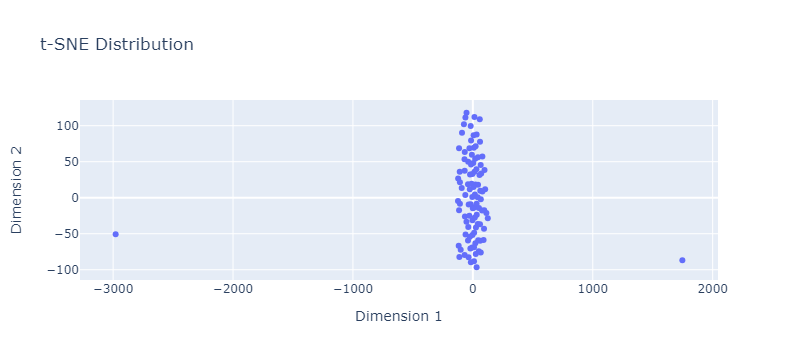

In [76]:
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_tsne.dim_1, y=df_tsne.dim_2, mode='markers', text=word_index_list))
fig.update_layout(title='t-SNE Distribution',xaxis_title='Dimension 1',yaxis_title='Dimension 2')

The above plot shows the 2-dimensional t-SNE distribution of the first 100 words from the Glove embedding. Each point on the plot represents a different word. Hovering on each point will show the word it represents. Proximity between two points indicates that the network sees the two words similarly. By looking through some of the points, it appears that the horizontal dimension ("Dimension 1") represents position within a sentence, i.e. if two words are close to each other horizontally, it means they appear close to each other in sentences frequently. The vertical dimension, on the other hand, appears to be more closely tied to *how* a word is used, not *where* it is used; i.e., if two words are close vertically, they are often used in the same way.